# Logistic Regression

In this example, we will learn a linear descision boundary to classify some data that can fall within
two classes. Two features (x and y coordinate) correspond to 1 label (which class)

In [1]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')

**Make a dataset**

Instead of finding a dataset we will make one up

In [2]:
file_path = "./datasets/basic_linear_classification.csv"
if not os.path.isfile(file_path):
    np.random.seed(42)
    N = 1000
    x_coords = np.random.uniform(low=-5.0, high=5.0, size=[N])
    y_coords = np.random.uniform(low=-5.0, high=5.0, size=[N])

    # lets decide that our dataset's true boundary is y = 2*x,
    # so points on one side are class A and points on the other are class B
    labelled_data = []
    for i in range(len(x_coords.flatten())):
        if y_coords[i] < 2*x_coords[i]:
            labelled_data.append([x_coords[i], y_coords[i], 1.0])
        else:
            labelled_data.append([x_coords[i], y_coords[i], 0.0])

    labelled_data = np.array(labelled_data).T
    print(f"Shape: {np.shape(labelled_data)}")
    np.savetxt(file_path, labelled_data, delimiter=",")
    print(f"Data daved to {file_path}")

    color_strings = ["red" if i == 1 else "blue" for i in labelled_data[2,:]]
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(labelled_data[0,:], labelled_data[1,:], color=color_strings, alpha=0.5)
    plt.show()
else:
    print(f"{file_path} already exists")

./datasets/basic_linear_classification.csv already exists


**Load the dataset**

We could use a PyTorch Dataset and DataLoader but it isn't necessary here.
I also use the `train_test_split` function from scikit-learn to easily split the data
into training and testing sets

In [3]:
data = np.loadtxt("./datasets/basic_linear_classification.csv",delimiter=",")
inputs = data[0:2,:].T
labels = data[2:,:].T.flatten()

X_train, X_test, y_train, y_test = train_test_split(
    inputs,
    labels,
    test_size=0.33,
    random_state=42
)
print(f"Training data:\ninputs: {X_train.shape}\nlabels: {y_train.shape}")
print(f"\nTesting data:\ninputs: {X_test.shape}\nlabels: {y_test.shape}")

# Convert to pytorch tensors
X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

Training data:
inputs: (670, 2)
labels: (670,)

Testing data:
inputs: (330, 2)
labels: (330,)


**Define a model**

In [4]:
# Define a linear logistic regression model
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self,input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [5]:
model = LogisticRegressionModel(2, 1) # 2 inputs (x,y) -> 1 label
criterion = torch.nn.BCELoss() # binary cross-entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

100%|██████████| 10000/10000 [00:05<00:00, 1939.15it/s]


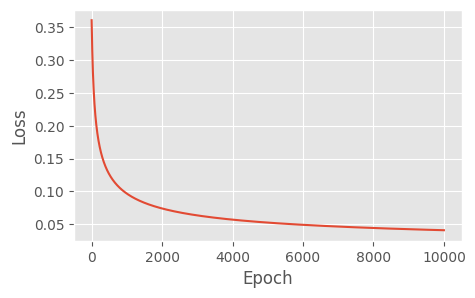

In [6]:
num_epochs = 10000
loss_hist = []

for epoch in tqdm(range(num_epochs)):

    # Forward pass to get a prediction
    pred = model(X_train)

    # Compute the loss
    loss = criterion(torch.squeeze(pred), y_train)
    loss_hist.append(loss.detach().float())

    # Zero the gradients, do a backwards pass, and take a gradient step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the loss history
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(list(range(num_epochs)), loss_hist)
ax.set(xlabel="Epoch",ylabel="Loss")
plt.show()

**Results**

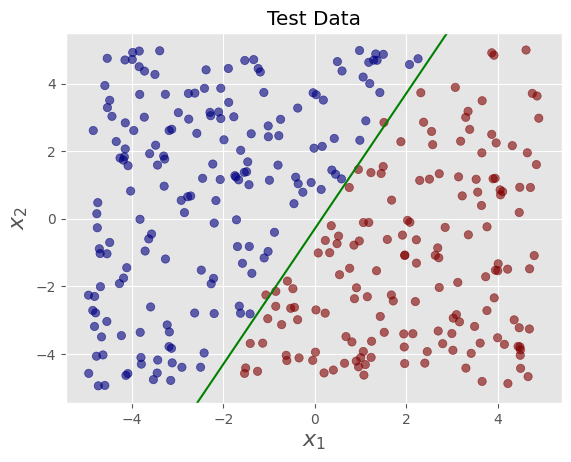

In [7]:
# found this function here: https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be
def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()

    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet', alpha=0.6)
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1], color="green")
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
    plt.title(title)
    plt.show()


# Train Data
# model_plot(model,X_train,y_train,'Train Data')

# Test Dataset Results
model_plot(model,X_test,y_test,'Test Data')